In [1]:
# !pip install matplotlib
# !pip install gurobipy
# !pip install torch_geometric

In [2]:
# !pip install scikit-learn

In [3]:
import gurobipy as gp
from gurobipy import GRB
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader  # Corrected import
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_mean_pool  # For pooling in the decoder
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import matplotlib.pyplot as plt  # For plotting losses

In [4]:
from parse_QP import my_callback

In [5]:
# Read the problem
number = "0031"
grb_model = gp.read(f"QPLIB_{number}.lp")

# Solution storage
grb_model._feasible_solutions = []
grb_model._relaxation_solutions = []
grb_model.setParam("MIPGap", 0.05)
#model.setParam("NodeLimit", 100)  # Explore a limited number of nodes

# Optimize
grb_model.optimize(my_callback)

Restricted license - for non-production use only - expires 2026-11-23
Read LP format model from file QPLIB_0031.lp
Reading time = 0.00 seconds
obj: 32 rows, 60 columns, 120 nonzeros
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel Xeon Processor (Icelake), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
MIPGap  0.05

Optimize a model with 32 rows, 60 columns and 120 nonzeros
Model fingerprint: 0x00d24133
Model has 464 quadratic objective terms
Variable types: 30 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e+01, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 3654.4800000
Presolve time: 0.00s
Presolved: 901 rows, 526 columns, 2321 nonzeros
Preso

In [6]:
# Retrieve optimal solution if available
if grb_model.status == GRB.OPTIMAL:
    optimal_solution = grb_model.getAttr('X', grb_model.getVars())
    print("Optimal solution:", optimal_solution)
else:
    print(f"Model status: {grb_model.status}")

Optimal solution: [0.0, 0.0, 0.3328307282391785, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1574644983911741, 0.25564451699144053, 0.0, 0.16105507040036132, 0.0, 0.0, 0.09300518597785103, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 1.0, 0.0, -0.0, -0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, -0.0, 0.0, 1.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]


In [7]:
## Extracting bounds

import gurobipy as gp

# Read the problem
number = "0031"
grb_model = gp.read(f"QPLIB_{number}.lp")

variable_bounds = {}
for var in grb_model.getVars():
    variable_bounds[var.VarName] = {'Lower': var.LB, 'Upper': var.UB}


Read LP format model from file QPLIB_0031.lp
Reading time = 0.00 seconds
obj: 32 rows, 60 columns, 120 nonzeros


In [8]:
## Extracting Q, A, b, d, etc

from parse_QP import parse_qplib_file

# Replace '0031' with the desired file number
data = parse_qplib_file('0031')

# Access the data
A = data['A']
b_vector = data['b_vector']
E = data['E']
d_vector = data['d']
Q = data['Q']
variables_info = data['variables_info']
variables_info = [v[0] for v in variables_info]
binary_indices = data['binary_indices']
variable_indices = data['variable_indices']

m, n = A.shape
# Get indices of non-zero elements in A
row_indices, col_indices = np.nonzero(A)
edge_weights = A[row_indices, col_indices]

# Map variable types to numerical values
# Node types: 0 - continuous, 1 - binary
variable_types = np.array([0 if v[0] == 'x' else 1 for v in variables_info])

# Collect indices of continuous and binary variables
continuous_indices = np.where(variable_types == 0)[0]
binary_indices = np.where(variable_types == 1)[0]
n_continuous = len(continuous_indices)
n_binary = len(binary_indices)
n_variables = n_continuous + n_binary


In [9]:
import os
import pickle
from generate_solutions import generate_feasible_solutions, generate_infeasible_solutions

# Set generate_new to False by default
generate_new = False
feasible_data_file = 'feasible_data.pkl'
infeasible_data_file = 'infeasible_data.pkl'
num_samples = 5000

# Load or generate feasible solutions (as in your original code)
if not generate_new and os.path.exists(feasible_data_file):
    # Load feasible data
    with open(feasible_data_file, 'rb') as f:
        feasible_data = pickle.load(f)
    feasible_solutions = feasible_data['solutions']
    feasible_costs = feasible_data['costs']
    print("Loaded existing feasible solutions from file.")
else:
    # Generate feasible solutions
    num_objectives = num_samples  # Adjust the number as needed
    feasible_solutions, feasible_costs = generate_feasible_solutions(
        A, E, Q, variables_info, b_vector, d_vector, num_objectives
    )
    # Save the generated data for future use
    feasible_data = {'solutions': feasible_solutions, 'costs': feasible_costs}
    with open(feasible_data_file, 'wb') as f:
        pickle.dump(feasible_data, f)
    print("Generated and saved feasible solutions.")

# Now, load or generate infeasible solutions
if not generate_new and os.path.exists(infeasible_data_file):
    # Load infeasible data
    with open(infeasible_data_file, 'rb') as f:
        infeasible_data = pickle.load(f)
    infeasible_solutions = infeasible_data['solutions']
    infeasible_costs = infeasible_data['costs']
    print("Loaded existing infeasible solutions from file.")
else:
    # Generate infeasible solutions
    num_infeasible_samples = num_samples  # Adjust as needed
    infeasible_solutions, infeasible_costs = generate_infeasible_solutions(
        A, E, variables_info, b_vector, d_vector, Q, num_infeasible_samples, feasible_solutions
    )
    # Save the generated data for future use
    infeasible_data = {'solutions': infeasible_solutions, 'costs': infeasible_costs}
    with open(infeasible_data_file, 'wb') as f:
        pickle.dump(infeasible_data, f)
    print("Generated and saved infeasible solutions.")


Loaded existing feasible solutions from file.
Loaded existing infeasible solutions from file.


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np

# Adjusted GNNModelObj to output variable node embeddings
class GNNModelObj(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNNModelObj, self).__init__()
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = F.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        return x  # Return embeddings for all variable nodes

# Adjusted GNNModelConstraints to output variable and constraint node embeddings
class GNNModelConstraints(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNNModelConstraints, self).__init__()
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = F.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x_var = x[data.variable_mask]
        x_constraints = x[~data.variable_mask]
        return x_var, x_constraints  # Return embeddings for both variables and constraints

# Define the JointGNN model
class JointGNN(torch.nn.Module):
    def __init__(self, hidden_channels_obj, hidden_channels_cons, decoder_hidden_channels):
        super(JointGNN, self).__init__()
        # Encoders
        self.encoder_obj = GNNModelObj(hidden_channels_obj)
        self.encoder_cons = GNNModelConstraints(hidden_channels_cons)
        # Decoder for x reconstruction
        concat_dim = hidden_channels_obj + hidden_channels_cons
        self.decoder_x = torch.nn.Sequential(
            torch.nn.Linear(concat_dim, decoder_hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(decoder_hidden_channels, 1)
        )
        # Decoder for cost prediction
        self.decoder_cost = torch.nn.Sequential(
            torch.nn.Linear(concat_dim, decoder_hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(decoder_hidden_channels, 1)
        )
        # Decoder for constraint violation prediction
        self.decoder_constraints = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels_cons, decoder_hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(decoder_hidden_channels, 1)
        )

    def forward(self, data_obj, data_feas):
        # Process data through encoders
        x_obj = self.encoder_obj(data_obj)  # Embeddings for variables
        x_cons_var, x_cons_constraints = self.encoder_cons(data_feas)  # Embeddings for variables and constraints
        # Extract variable embeddings
        x_obj_var = x_obj[data_obj.variable_mask]
        # Concatenate per-variable embeddings
        x_var = torch.cat([x_obj_var, x_cons_var], dim=1)
        # Decode to reconstruct x
        x_hat = self.decoder_x(x_var).squeeze()
        # Compute mean pooling over variable nodes for cost prediction
        batch = data_obj.batch[data_obj.variable_mask]
        x_var_pooled = global_mean_pool(x_var, batch)  # [batch_size, concat_dim]
        # Predict cost
        predicted_cost = self.decoder_cost(x_var_pooled).squeeze()
        # Decode to predict constraint violations
        predicted_constraints = self.decoder_constraints(x_cons_constraints).squeeze()
        return x_hat, predicted_cost, predicted_constraints

# Custom dataset to return pairs of data_obj and data_feas
class JointDataset(Dataset):
    def __init__(self, data_list_obj, data_list_feas):
        assert len(data_list_obj) == len(data_list_feas)
        self.data_list_obj = data_list_obj
        self.data_list_feas = data_list_feas

    def __len__(self):
        return len(self.data_list_obj)

    def __getitem__(self, idx):
        return self.data_list_obj[idx], self.data_list_feas[idx]

# Custom collate function for batching
def joint_collate_fn(batch):
    data_obj_list, data_feas_list = zip(*batch)
    batch_obj = Batch.from_data_list(data_obj_list)
    batch_feas = Batch.from_data_list(data_feas_list)
    return batch_obj, batch_feas

# Data preparation functions
def prepare_edge_index_and_attr(Q):
    n_variables = Q.shape[0]
    edge_index = []
    edge_attr = []
    Q = Q if isinstance(Q, np.ndarray) else Q.toarray()
    for i in range(n_variables):
        for j in range(n_variables):
            if Q[i, j] != 0:
                edge_index.append([i, j])
                edge_attr.append(Q[i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return edge_index, edge_attr

def prepare_constraint_edge_data(A, E, n_variables):
    # A: m x n, E: p x n
    m = A.shape[0]
    p = E.shape[0]
    num_constraints = m + p
    edge_index = []
    edge_attr = []
    # Edges from variables to inequality constraints
    for constraint_idx in range(m):
        for variable_idx in range(n_variables):
            coeff = A[constraint_idx, variable_idx]
            if coeff != 0:
                # Edge from variable to constraint
                edge_index.append([variable_idx, n_variables + constraint_idx])
                edge_attr.append(coeff)
    # Edges from variables to equality constraints
    for constraint_idx in range(p):
        for variable_idx in range(n_variables):
            coeff = E[constraint_idx, variable_idx]
            if coeff != 0:
                # Edge from variable to constraint
                edge_index.append([variable_idx, n_variables + m + constraint_idx])
                edge_attr.append(coeff)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return edge_index, edge_attr

def create_data_list_obj(solutions, costs, edge_index, edge_attr):
    data_list = []
    for x_sol, cost_sol in zip(solutions, costs):
        x = torch.tensor(x_sol, dtype=torch.float).unsqueeze(-1)
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        data.variable_mask = torch.ones(data.num_nodes, dtype=torch.bool)
        data.y_x = x.squeeze()
        data.y_cost = torch.tensor([cost_sol], dtype=torch.float)
        data_list.append(data)
    return data_list

def create_data_list_feas(solutions, costs, A, E, b_vector, d_vector, edge_index, edge_attr, n_variables):
    data_list = []
    m = A.shape[0]
    p = E.shape[0]
    num_constraints = m + p
    for x_sol, cost_sol in zip(solutions, costs):
        x_vars = torch.tensor(x_sol, dtype=torch.float).unsqueeze(-1)
        # Constraint node features: b_vector and d_vector
        b = torch.tensor(b_vector, dtype=torch.float).unsqueeze(-1)
        d = torch.tensor(d_vector, dtype=torch.float).unsqueeze(-1)
        x_constraints = torch.cat([b, d], dim=0)
        x_total = torch.cat([x_vars, x_constraints], dim=0)
        data = Data(x=x_total, edge_index=edge_index, edge_attr=edge_attr)
        data.variable_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.variable_mask[:n_variables] = True  # Variables are first
        data.y_x = x_vars.squeeze()
        data.y_cost = torch.tensor([cost_sol], dtype=torch.float)

        # Compute constraint violations
        A_tensor = torch.tensor(A, dtype=torch.float)
        E_tensor = torch.tensor(E, dtype=torch.float)
        inequality_violations = torch.mv(A_tensor, x_vars.squeeze()) - torch.tensor(b_vector, dtype=torch.float)
        equality_violations = torch.mv(E_tensor, x_vars.squeeze()) - torch.tensor(d_vector, dtype=torch.float)
        y_constraints = torch.cat([inequality_violations, equality_violations], dim=0)
        data.y_constraints = y_constraints  # [num_constraints]
        data_list.append(data)
    return data_list

def normalize_node_features(data_list):
    # Concatenate all node features from all graphs
    x_all = torch.cat([data.x for data in data_list], dim=0)
    mean = x_all.mean(dim=0)
    std = x_all.std(dim=0) + 1e-6  # Avoid division by zero
    for data in data_list:
        data.x = (data.x - mean) / std
    return data_list, mean, std

def normalize_targets(data_list):
    # Normalize y_x (node targets)
    y_x_all = torch.cat([data.y_x for data in data_list], dim=0)
    mean_y_x = y_x_all.mean()
    std_y_x = y_x_all.std() + 1e-6
    for data in data_list:
        data.y_x = (data.y_x - mean_y_x) / std_y_x

    # Normalize y_cost (graph targets)
    y_cost_all = torch.cat([data.y_cost for data in data_list], dim=0)
    mean_y_cost = y_cost_all.mean()
    std_y_cost = y_cost_all.std() + 1e-6
    for data in data_list:
        data.y_cost = (data.y_cost - mean_y_cost) / std_y_cost

    # Initialize means and stds for y_constraints
    mean_y_constraints = None
    std_y_constraints = None

    # Normalize y_constraints if present
    if hasattr(data_list[0], 'y_constraints'):
        y_constraints_all = torch.cat([data.y_constraints for data in data_list], dim=0)
        mean_y_constraints = y_constraints_all.mean()
        std_y_constraints = y_constraints_all.std() + 1e-6
        for data in data_list:
            data.y_constraints = (data.y_constraints - mean_y_constraints) / std_y_constraints

    return data_list, (mean_y_x, std_y_x), (mean_y_cost, std_y_cost), (mean_y_constraints, std_y_constraints)

def split_data(data_list, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.random.permutation(len(data_list))
    test_set_size = int(len(data_list) * test_size)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    train_data = [data_list[i] for i in train_indices]
    test_data = [data_list[i] for i in test_indices]
    return train_data, test_data

# Assume you have the following variables defined:
# Q, A, E, b_vector, d_vector, feasible_solutions, feasible_costs, infeasible_solutions, infeasible_costs, n_variables

# Prepare edge information from Q
edge_index_obj, edge_attr_obj = prepare_edge_index_and_attr(Q)

# Prepare edge information from A and E
edge_index_feas, edge_attr_feas = prepare_constraint_edge_data(A, E, n_variables)

# Create Data objects for feasible solutions
data_list_obj_feas = create_data_list_obj(feasible_solutions, feasible_costs, edge_index_obj, edge_attr_obj)
data_list_feas_feas = create_data_list_feas(feasible_solutions, feasible_costs, A, E, b_vector, d_vector, edge_index_feas, edge_attr_feas, n_variables)

# Create Data objects for infeasible solutions
data_list_obj_infeas = create_data_list_obj(infeasible_solutions, infeasible_costs, edge_index_obj, edge_attr_obj)
data_list_feas_infeas = create_data_list_feas(infeasible_solutions, infeasible_costs, A, E, b_vector, d_vector, edge_index_feas, edge_attr_feas, n_variables)

# Combine feasible and infeasible data
data_list_obj = data_list_obj_feas + data_list_obj_infeas
data_list_feas = data_list_feas_feas + data_list_feas_infeas

# Normalize node features for data_list_obj
data_list_obj, mean_obj, std_obj = normalize_node_features(data_list_obj)

# Normalize node features for data_list_feas
data_list_feas, mean_feas, std_feas = normalize_node_features(data_list_feas)

# Normalize targets (x and cost) for data_list_obj
data_list_obj, (mean_y_x, std_y_x), (mean_y_cost, std_y_cost), _ = normalize_targets(data_list_obj)

# Normalize targets (x, cost, and constraints) for data_list_feas
data_list_feas, _, _, (mean_y_constraints, std_y_constraints) = normalize_targets(data_list_feas)

# Split into train and test sets
train_data_obj, test_data_obj = split_data(data_list_obj, test_size=0.2, random_state=42)
train_data_feas, test_data_feas = split_data(data_list_feas, test_size=0.2, random_state=42)

# Create datasets and data loaders
train_dataset = JointDataset(train_data_obj, train_data_feas)
test_dataset = JointDataset(test_data_obj, test_data_feas)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=joint_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=joint_collate_fn)

# Initialize model, optimizer, and loss function
model = JointGNN(hidden_channels_obj=256, hidden_channels_cons=128, decoder_hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training and testing functions
def train():
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_cost_loss = 0
    total_constraint_loss = 0
    total_original_cost_loss = 0
    total_original_constraint_loss = 0
    for data_obj_batch, data_feas_batch in train_loader:
        optimizer.zero_grad()
        x_hat, predicted_cost, predicted_constraints = model(data_obj_batch, data_feas_batch)
        # Get target x values and cost values
        y_x = data_obj_batch.y_x
        y_cost = data_obj_batch.y_cost.squeeze()
        y_constraints = data_feas_batch.y_constraints
        # Compute reconstruction loss
        recon_loss = criterion(x_hat, y_x)
        # Compute cost prediction loss
        cost_loss = criterion(predicted_cost, y_cost)
        # Compute constraint violation loss
        constraint_loss = criterion(predicted_constraints, y_constraints)
        # Total loss (weighted sum)
        loss = recon_loss + cost_loss + constraint_loss  # You can adjust weights if desired
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data_obj_batch.num_graphs
        total_recon_loss += recon_loss.item() * data_obj_batch.num_graphs
        total_cost_loss += cost_loss.item() * data_obj_batch.num_graphs
        total_constraint_loss += constraint_loss.item() * data_obj_batch.num_graphs

        # Compute original cost loss (denormalized)
        predicted_cost_orig = predicted_cost * std_y_cost + mean_y_cost
        y_cost_orig = y_cost * std_y_cost + mean_y_cost
        original_cost_loss = criterion(predicted_cost_orig, y_cost_orig)
        total_original_cost_loss += original_cost_loss.item() * data_obj_batch.num_graphs

        # Compute original constraint loss (denormalized)
        predicted_constraints_orig = predicted_constraints * std_y_constraints + mean_y_constraints
        y_constraints_orig = y_constraints * std_y_constraints + mean_y_constraints
        original_constraint_loss = criterion(predicted_constraints_orig, y_constraints_orig)
        total_original_constraint_loss += original_constraint_loss.item() * data_obj_batch.num_graphs

    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_cost_loss = total_cost_loss / len(train_loader.dataset)
    avg_constraint_loss = total_constraint_loss / len(train_loader.dataset)
    avg_original_cost_loss = total_original_cost_loss / len(train_loader.dataset)
    avg_original_constraint_loss = total_original_constraint_loss / len(train_loader.dataset)
    return avg_loss, avg_recon_loss, avg_cost_loss, avg_constraint_loss, avg_original_cost_loss, avg_original_constraint_loss

def test(loader):
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_cost_loss = 0
    total_constraint_loss = 0
    total_original_cost_loss = 0
    total_original_constraint_loss = 0
    with torch.no_grad():
        for data_obj_batch, data_feas_batch in loader:
            x_hat, predicted_cost, predicted_constraints = model(data_obj_batch, data_feas_batch)
            y_x = data_obj_batch.y_x
            y_cost = data_obj_batch.y_cost.squeeze()
            y_constraints = data_feas_batch.y_constraints
            recon_loss = criterion(x_hat, y_x)
            cost_loss = criterion(predicted_cost, y_cost)
            constraint_loss = criterion(predicted_constraints, y_constraints)
            loss = recon_loss + cost_loss + constraint_loss
            total_loss += loss.item() * data_obj_batch.num_graphs
            total_recon_loss += recon_loss.item() * data_obj_batch.num_graphs
            total_cost_loss += cost_loss.item() * data_obj_batch.num_graphs
            total_constraint_loss += constraint_loss.item() * data_obj_batch.num_graphs

            # Compute original cost loss (denormalized)
            predicted_cost_orig = predicted_cost * std_y_cost + mean_y_cost
            y_cost_orig = y_cost * std_y_cost + mean_y_cost
            original_cost_loss = criterion(predicted_cost_orig, y_cost_orig)
            total_original_cost_loss += original_cost_loss.item() * data_obj_batch.num_graphs

            # Compute original constraint loss (denormalized)
            predicted_constraints_orig = predicted_constraints * std_y_constraints + mean_y_constraints
            y_constraints_orig = y_constraints * std_y_constraints + mean_y_constraints
            original_constraint_loss = criterion(predicted_constraints_orig, y_constraints_orig)
            total_original_constraint_loss += original_constraint_loss.item() * data_obj_batch.num_graphs

    avg_loss = total_loss / len(loader.dataset)
    avg_recon_loss = total_recon_loss / len(loader.dataset)
    avg_cost_loss = total_cost_loss / len(loader.dataset)
    avg_constraint_loss = total_constraint_loss / len(loader.dataset)
    avg_original_cost_loss = total_original_cost_loss / len(loader.dataset)
    avg_original_constraint_loss = total_original_constraint_loss / len(loader.dataset)
    return avg_loss, avg_recon_loss, avg_cost_loss, avg_constraint_loss, avg_original_cost_loss, avg_original_constraint_loss

# Training loop
num_epochs = 10
test_loss, test_recon_loss, test_cost_loss, test_constraint_loss, test_orig_cost_loss, test_orig_constraint_loss = test(test_loader)

print(f"Pre-Test Loss: {test_loss:.4f}, Recon Loss: {test_recon_loss:.4f}, "
      f"Cost Loss: {test_cost_loss:.4f}, Constraint Loss: {test_constraint_loss:.4f}")

for epoch in range(1, num_epochs + 1):
    # Unpack all six returned values
    train_loss, train_recon_loss, train_cost_loss, train_constraint_loss, train_orig_cost_loss, train_orig_constraint_loss = train()
    test_loss, test_recon_loss, test_cost_loss, test_constraint_loss, test_orig_cost_loss, test_orig_constraint_loss = test(test_loader)

    print("----")
    # Print out all the losses
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Recon Loss: {train_recon_loss:.4f}, "
          f"Cost Loss: {train_cost_loss:.4f}, Constraint Loss: {train_constraint_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Recon Loss: {test_recon_loss:.4f}, "
          f"Cost Loss: {test_cost_loss:.4f}, Constraint Loss: {test_constraint_loss:.4f}")
    print("----")


Pre-Test Loss: 2.4887, Recon Loss: 1.0111, Cost Loss: 0.5489, Constraint Loss: 0.9286
----
Epoch 1, Train Loss: 0.7501, Recon Loss: 0.0765, Cost Loss: 0.3620, Constraint Loss: 0.3116
Test Loss: 0.0926, Recon Loss: 0.0001, Cost Loss: 0.0649, Constraint Loss: 0.0277
----
----
Epoch 2, Train Loss: 0.1445, Recon Loss: 0.0002, Cost Loss: 0.1373, Constraint Loss: 0.0069
Test Loss: 0.0940, Recon Loss: 0.0000, Cost Loss: 0.0699, Constraint Loss: 0.0241
----
----
Epoch 3, Train Loss: 0.1177, Recon Loss: 0.0002, Cost Loss: 0.1126, Constraint Loss: 0.0050
Test Loss: 0.0660, Recon Loss: 0.0000, Cost Loss: 0.0427, Constraint Loss: 0.0232
----
----
Epoch 4, Train Loss: 0.0987, Recon Loss: 0.0001, Cost Loss: 0.0945, Constraint Loss: 0.0041
Test Loss: 0.0515, Recon Loss: 0.0000, Cost Loss: 0.0286, Constraint Loss: 0.0229
----
----
Epoch 5, Train Loss: 0.0877, Recon Loss: 0.0001, Cost Loss: 0.0839, Constraint Loss: 0.0037
Test Loss: 0.0637, Recon Loss: 0.0000, Cost Loss: 0.0420, Constraint Loss: 0.0216

In [31]:
# Use a batch of data
data_obj_batch, data_feas_batch = next(iter(test_loader))
with torch.no_grad():
    # Encode and decode
    z_obj = model.encoder_obj(data_obj_batch)
    z_cons_var, z_constraints = model.encoder_cons(data_feas_batch)
    x_obj_var = z_obj[data_obj_batch.variable_mask]
    x_var = torch.cat([x_obj_var, z_cons_var], dim=1)
    x_hat = model.decoder_x(x_var).squeeze()
    # Denormalize x_hat and y_x
    x_hat_denorm = x_hat * std_y_x + mean_y_x
    y_x_denorm = data_obj_batch.y_x * std_y_x + mean_y_x
    # Compute reconstruction error
    recon_error = torch.norm(x_hat_denorm - y_x_denorm)
    print(f"Decoder Reconstruction Error: {recon_error.item()}")


Decoder Reconstruction Error: 0.061145491898059845


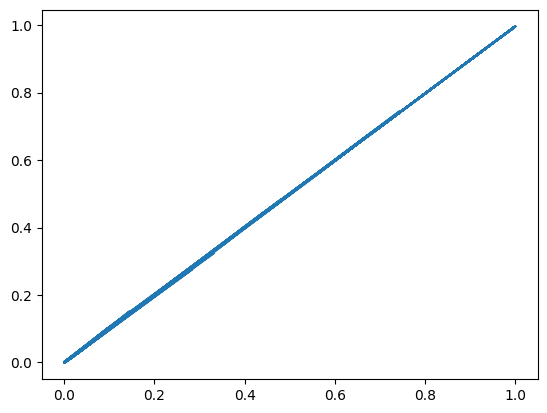

In [32]:
plt.plot(y_x_denorm.cpu().numpy(), np.round(x_hat_denorm, 3).cpu().numpy())

In [33]:
def evaluate_predictions(model, data_list_obj, data_list_feas):
    model.eval()
    actual_costs = []
    predicted_costs = []
    actual_constraints = []
    predicted_constraints_list = []  # Renamed the list
    with torch.no_grad():
        for data_obj, data_feas in zip(data_list_obj, data_list_feas):
            # Get the true x
            y_x = data_obj.y_x * std_y_x + mean_y_x  # [n_variables]
            y_x_np = y_x.detach().numpy()  # Shape: (n_variables,)
            # Compute actual cost
            actual_cost = 0.5 * y_x_np.T @ Q @ y_x_np  # Scalar
            actual_costs.append(actual_cost)
            # Compute actual constraint violations
            inequality_violations = A @ y_x_np - b_vector  # Shape: (num_inequality_constraints,)
            equality_violations = E @ y_x_np - d_vector    # Shape: (num_equality_constraints,)
            actual_constraint = np.concatenate((inequality_violations, equality_violations))  # Shape: (num_constraints,)
            actual_constraints.extend(actual_constraint)
            # Get model predictions
            # Prepare batch data for model input
            data_obj_batch = Batch.from_data_list([data_obj])
            data_feas_batch = Batch.from_data_list([data_feas])
            x_hat, predicted_cost, predicted_constraints = model(data_obj_batch, data_feas_batch)
            # Denormalize predicted cost and constraints
            predicted_cost_denorm = (predicted_cost.item() * std_y_cost + mean_y_cost)
            predicted_constraints_denorm = (predicted_constraints * std_y_constraints + mean_y_constraints).detach().numpy()
            predicted_costs.append(predicted_cost_denorm)
            predicted_constraints_list.extend(predicted_constraints_denorm)  # Use the renamed list
    # Compute correlations
    cost_correlation = np.corrcoef(actual_costs, predicted_costs)[0,1]
    constraint_correlation = np.corrcoef(np.array(actual_constraints), np.array(predicted_constraints_list))[0,1]
    print(f"Cost Prediction Correlation: {cost_correlation}")
    print(f"Constraint Prediction Correlation: {constraint_correlation}")


In [34]:
# Assuming you have test_data_obj and test_data_feas
evaluate_predictions(model, test_data_obj, test_data_feas)


Cost Prediction Correlation: 0.9901578312283295
Constraint Prediction Correlation: 0.9964371730046403
